In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import 

from mmengine.config import Config
from mmdet.apis import init_detector, inference_detector
from mmcv import imread
import sys
# sys.path.append('/Ziob/343312/AVD-Anonymizer/CrossKD/tools/analysis_tools')


In [2]:
def get_module_by_path(root, path: str):
    cur = root
    for p in path.split("."):
        if p == "":
            continue
        if p.lstrip("-").isdigit():  # support negative idx too
            cur = cur[int(p)]
        else:
            cur = getattr(cur, p)
    return cur

def resolve_target_module(model, primary_path, fallbacks=()):
    tried = [primary_path] + list(fallbacks)
    last_err = None
    for p in tried:
        try:
            return get_module_by_path(model, p), p
        except Exception as e:
            last_err = e
    raise RuntimeError(f"Could not resolve any target module from: {tried}\nLast error: {last_err}")

def preprocess_like_dp(model, img_bgr):
    dp = model.data_preprocessor
    img = img_bgr[..., ::-1].copy() if getattr(dp, "bgr_to_rgb", True) else img_bgr.copy()
    x = torch.from_numpy(img).permute(2, 0, 1).float().unsqueeze(0)  # [1,3,H,W], 0..255
    x = x.to(next(model.parameters()).device)
    mean = torch.tensor(dp.mean, dtype=x.dtype, device=x.device).view(1, 3, 1, 1)
    std  = torch.tensor(dp.std,  dtype=x.dtype, device=x.device).view(1, 3, 1, 1)
    x = (x - mean) / std
    div = int(getattr(dp, "pad_size_divisor", 1) or 1)
    _, _, H, W = x.shape
    if div > 1:
        Hn = (H + div - 1) // div * div
        Wn = (W + div - 1) // div * div
        if Hn != H or Wn != W:
            x = F.pad(x, (0, Wn - W, 0, Hn - H))
    return x, img  # tensor, RGB uint8 image

def compute_cam_for_strongest_logit(model, x, target_module):
    acts, grads = {}, {}
    def fwd_hook(m, inp, out): acts["A"] = out
    def bwd_hook(m, gin, gout): grads["dA"] = gout[0]

    fh = target_module.register_forward_hook(fwd_hook)
    bh = target_module.register_full_backward_hook(bwd_hook)

    with torch.enable_grad():
        x.requires_grad_(True)
        feats = model.extract_feat(x)
        cls_scores, bbox_preds, centernesses = model.bbox_head(feats)


        strongest = None
        for t in cls_scores: 
            flat = t.view(t.size(0), -1)
            idx = flat.abs().argmax(dim=1)
            sel = flat[0, idx[0]]
            if strongest is None or sel.item() > strongest.item():
                strongest = sel
        strongest.backward(retain_graph=False)

    A = acts["A"]          # (N,C,h,w)
    dA = grads["dA"]       # (N,C,h,w)
    weights = dA.mean(dim=(2, 3), keepdim=True)   # GAP over spatial
    cam = (A * weights).sum(dim=1, keepdim=True)  # (N,1,h,w)
    cam = F.relu(cam)

    cam = cam - cam.amin(dim=(2,3), keepdim=True)
    cam = cam / (cam.amax(dim=(2,3), keepdim=True) + 1e-6)

    cam_up = F.interpolate(cam, size=x.shape[-2:], mode="bilinear", align_corners=False)[0,0]
    fh.remove(); bh.remove()
    return cam_up

def get_dets(model, img_path, thr=0.):
    det = inference_detector(model, img_path)
    bboxes = []
    if isinstance(det, dict) and "pred_instances" in det:
        inst = det["pred_instances"]
        b = inst.bboxes.detach().cpu().numpy()
        s = inst.scores.detach().cpu().numpy()
        keep = s >= thr
        bboxes = b[keep]
    elif isinstance(det, list):
        for cls_id, arr in enumerate(det):
            if arr is None or len(arr) == 0:
                continue
            for bb in arr:
                x1, y1, x2, y2, score = bb.tolist()
                if score >= thr:
                    bboxes.append([x1, y1, x2, y2])
        bboxes = np.array(bboxes, dtype=np.float32) if bboxes else np.zeros((0,4), dtype=np.float32)
    return bboxes

def overlay(rgb_uint8, cam_01, alpha=0.45):
    rgb = rgb_uint8.astype(np.float32) / 255.0
    cam_np = cam_01.detach().cpu().numpy()
    heat = plt.cm.jet(cam_np)[..., :3]  # colormap to RGB
    out = (1 - alpha) * rgb + alpha * heat
    return np.clip(out, 0, 1)


def plot_one(ov, bxs, color, save_path=None):
    plt.figure(figsize=(7, 6))
    plt.imshow(ov)
    plt.title(title)
    plt.axis("off")
    for bb in bxs:
        x1, y1, x2, y2 = bb
        plt.gca().add_patch(Rectangle((x1, y1), x2 - x1, y2 - y1,
                                      fill=False, lw=2.0, ec=color))
    plt.tight_layout()
    if save_path is not None:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=200, bbox_inches="tight", pad_inches=0.1)
    plt.show()
    plt.close()





In [3]:
img_path = "data/pp4av_dataset/val/00064_RV.png"

cfg_a = "configs/fcos/fcos_r101-caffe_fpn_gn-head-1x_coco.py"
ckpt_a = "work_dirs/fcos_r101-caffe_fpn_gn-head-1x_coco/exp_1/epoch_24.pth"
target_a = "backbone.layer4.-1"      # last block of layer4

cfg_b = 'configs/crosskd/crosskd_r50_fcos_pp4av.py'
ckpt_b = 'work_dirs/crosskd_r50_fcos_pp4av/exp_2/epoch_24.pth'
target_b = "backbone.layer4.-1"    

device = "cuda:0"
BOX_THR = 0.5
ALPHA = 0.5 

Loads checkpoint by local backend from path: work_dirs/fcos_r101-caffe_fpn_gn-head-1x_coco/exp_1/epoch_24.pth
Loads checkpoint by local backend from path: work_dirs/fcos_r101-caffe_fpn_gn-head-1x_coco/exp_2/epoch_24.pth
Loads checkpoint by local backend from path: work_dirs/crosskd_r50_fcos_pp4av/exp_2/epoch_24.pth


/tmp/ipykernel_2343943/2071782093.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(dp.mean, dtype=x.dtype, device=x.device).view(1, 3, 1, 1)
/tmp/ipykernel_2343943/2071782093.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std  = torch.tensor(dp.std,  dtype=x.dtype, device=x.device).view(1, 3, 1, 1)


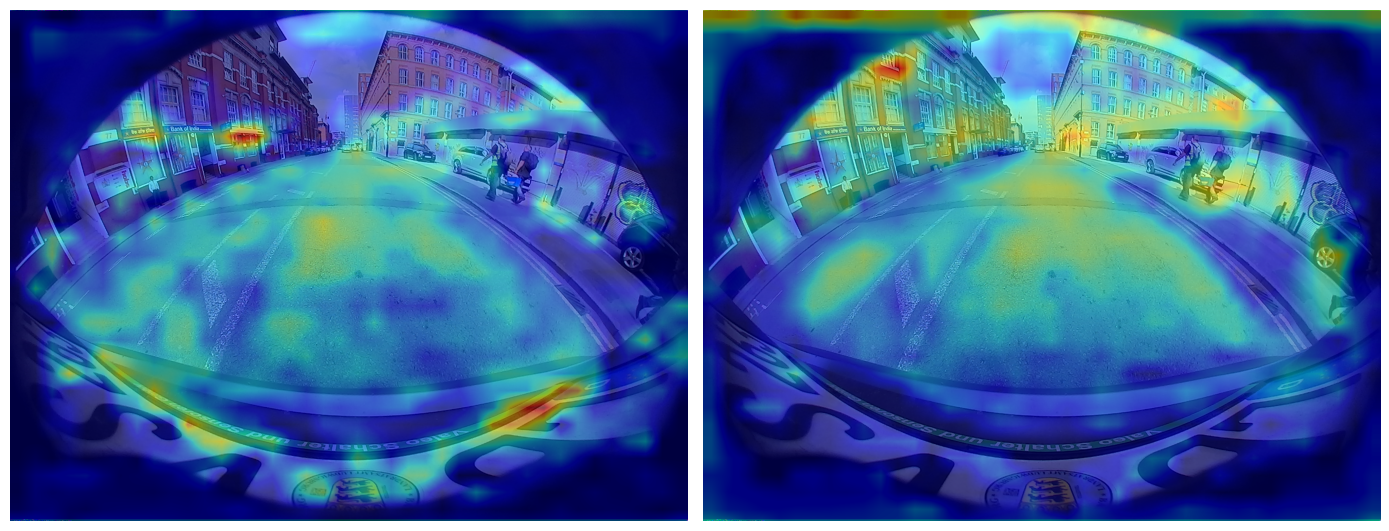

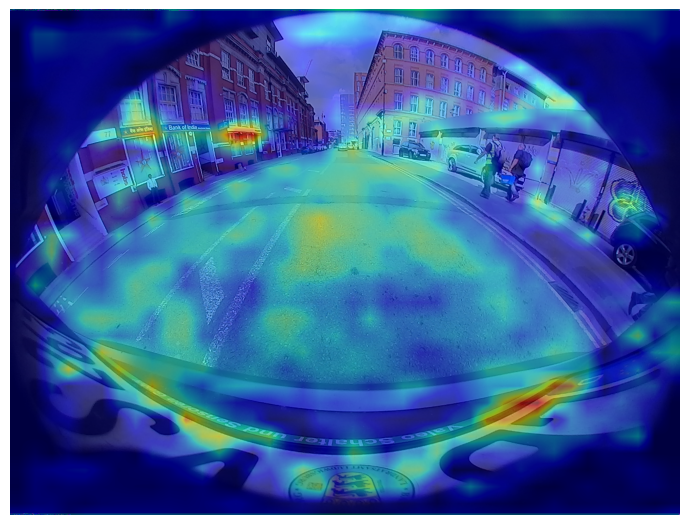

In [6]:
cfgA = Config.fromfile(cfg_a);  modelA = init_detector(cfgA, ckpt_a, device=device);  modelA.eval()
cfgB = Config.fromfile(cfg_b);  modelB = init_detector(cfgB, ckpt_b, device=device);  modelB.eval()

tgtA, usedA = resolve_target_module(modelA, target_a)
tgtB, usedB = resolve_target_module(
    modelB,
    target_b,
    fallbacks=[
        "student.backbone.layer4.-1",            
        "model.backbone.layer4.-1",
        "backbone.layer4.1",                    
    ],
)

img_bgr = imread(img_path)
xA, img_rgb = preprocess_like_dp(modelA, img_bgr)
xB, _       = preprocess_like_dp(modelB, img_bgr)  


orig_h, orig_w = img_rgb.shape[:2]

camA = compute_cam_for_strongest_logit(modelA, xA, tgtA)[:orig_h, :orig_w]
camB = compute_cam_for_strongest_logit(modelB, xB, tgtB)[:orig_h, :orig_w]

bA = get_dets(modelA, img_path, BOX_THR)
bB = get_dets(modelB, img_path, BOX_THR)

ovA = overlay(img_rgb, camA, ALPHA)
ovB = overlay(img_rgb, camB, ALPHA)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for ax, ov, bxs, title, color in [
    (axes[0], ovA, bA, '', "black"),
    (axes[1], ovB, bB, '', "white"),
]:
    ax.imshow(ov)
    ax.set_title(title)
    ax.axis("off")
    for bb in bxs:
        x1, y1, x2, y2 = bb
        ax.add_patch(Rectangle((x1, y1), x2-x1, y2-y1, fill=False, lw=2.0, ec=color))
plt.tight_layout()
plt.show()

plot_one(
    ovA, bA,
#     f"A) FCOS-R101  |  layer={usedA}",
    color="black",
#     save_path="outputs/cams/cam_fcos_r101.png"
)